In [1]:
import numpy as np
import pandas as pd

import pystan
import arviz

import matplotlib.pyplot as plt

In [4]:
def is_incident_smoker(arr):
    arr = arr.values
    if len(arr) == 1 or arr[0] == 1:
        return False
    try:
        first_idx = np.argwhere(arr == 1)[0][0]
        return np.mean(arr[first_idx : len(arr)]) == 1
    except IndexError as ex:
        return False

In [40]:
def calculate_incident_smokers_test_statistic(
    params, df_y_rep, is_incident_smoker
):
    ts = []
    for i in range(params["y_pred"].shape[0]):
        tmp_df = pd.DataFrame(
            {"smkreg": params["y_pred"][i], "newid": df_y_rep["newid"]}
        )
        ts.append(
            np.mean(tmp_df.groupby("newid")["smkreg"].agg(is_incident_smoker))
        )
    return ts

### Load data

In [2]:
smoking_data = pd.read_table("../utilities_and_data/smoking/smoke_pub.dat")
num_people = smoking_data["newid"].nunique()
smoking_data["mean_waves_smoked"] = smoking_data.groupby("newid")[
    "smkreg"
].transform("mean")

never_smokers_test_statistic_y = (
    smoking_data.groupby("newid")["smkreg"].agg("mean") == 0
).mean()
always_smokers_test_statistic_y = (
    smoking_data.groupby("newid")["smkreg"].agg("mean") == 1
).mean()

incident_smokers_test_statistic_y = np.mean(
    smoking_data.groupby("newid")["smkreg"].agg(is_incident_smoker)
)

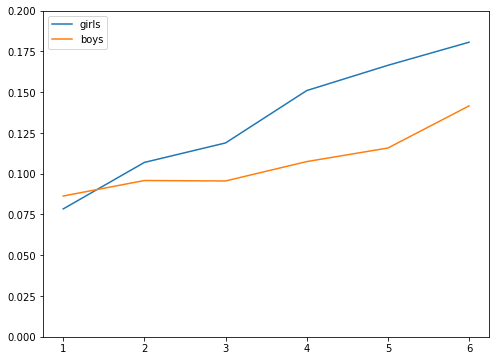

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(
    smoking_data.loc[smoking_data["sex(1=F)"] == 1]
    .groupby("wave")["smkreg"]
    .mean(),
    label="girls",
)
ax.plot(
    smoking_data.loc[smoking_data["sex(1=F)"] == 0]
    .groupby("wave")["smkreg"]
    .mean(),
    label="boys",
)
ax.set_ylim(0, 0.2)
ax.legend();

### Fit model

In [8]:
model = pystan.StanModel("stan_models/smoking.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_464947f85f6b4f3d68824aec3d50eef4 NOW.


In [9]:
stan_data = {
    "N_people": num_people,
    "N": len(smoking_data),
    "parent_smoke": smoking_data["parsmk"],
    "female": smoking_data["sex(1=F)"],
    "t": smoking_data["wave"],
    "smoke": smoking_data["smkreg"],
    "p_idx": smoking_data["newid"],
}

In [10]:
fit = model.sampling(stan_data, iter=1000)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [11]:
params = fit.extract(permuted=True)
var_names = ["b0", "b1", "b2", "b3", "b4", "sigma_alpha"]

In [12]:
inference_data = arviz.convert_to_inference_data(fit)
summary_df = (
    arviz.summary(inference_data, var_names=var_names)
    .reset_index()
    .rename(columns={"index": "parameter"})
)

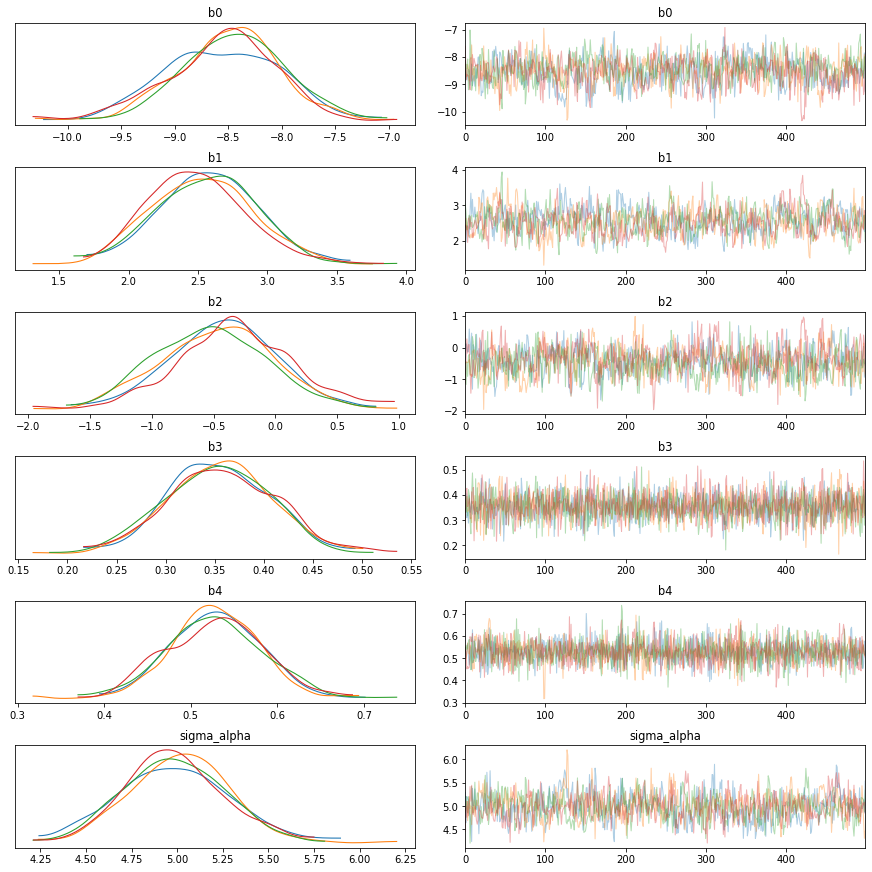

In [14]:
arviz.plot_trace(fit, var_names=var_names);

### Posterior predictive checking

In [30]:
df_y_rep = pd.DataFrame(params["y_pred"]).T
df_y_rep["newid"] = smoking_data["newid"].values
df_y_rep_mean_per_person = df_y_rep.groupby("newid").mean().values

In [33]:
qs = [0.025, 0.975]

never_smokers_test_statistic = (df_y_rep_mean_per_person == 0).mean(0)
never_smokers_quantiles = np.quantile(never_smokers_test_statistic, q=qs)

always_smokers_test_statistic = (df_y_rep_mean_per_person == 1).mean(0)
always_smokers_quantiles = np.quantile(always_smokers_test_statistic, q=qs)

incident_smokers_test_statistic = calculate_incident_smokers_test_statistic(
    params, df_y_rep, is_incident_smoker
)
incident_smokers_quantiles = np.quantile(incident_smokers_test_statistic, q=qs)

In [55]:
never_smokers_p_value = np.mean(
    never_smokers_test_statistic > never_smokers_test_statistic_y
)
always_smokers_p_value = np.mean(
    always_smokers_test_statistic > always_smokers_test_statistic_y
)
incident_smokers_p_value = np.mean(
    incident_smokers_test_statistic > incident_smokers_test_statistic_y
)

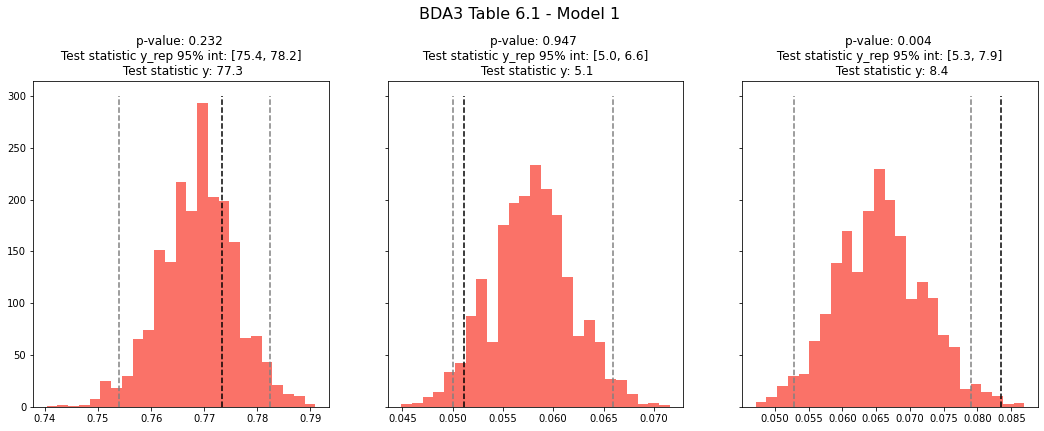

In [77]:
bins = 25
vline_height = 300

fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

ax[0].hist(never_smokers_test_statistic, bins=bins, color="#fa7268")
ax[0].vlines(
    never_smokers_quantiles[0], 0, vline_height, linestyle="--", color="grey"
)
ax[0].vlines(
    never_smokers_quantiles[1], 0, vline_height, linestyle="--", color="grey"
)
ax[0].vlines(
    never_smokers_test_statistic_y,
    0,
    vline_height,
    linestyle="--",
    label="$T(y)$",
)
ax[0].set_title(
    f"p-value: {never_smokers_p_value:.3f} \n Test statistic y_rep 95% int: [{never_smokers_quantiles[0]*100:.1f}, {never_smokers_quantiles[1]*100:.1f}] \n Test statistic y: {never_smokers_test_statistic_y*100:.1f}"
)

ax[1].hist(always_smokers_test_statistic, bins=bins, color="#fa7268")
ax[1].vlines(
    always_smokers_quantiles[0], 0, vline_height, linestyle="--", color="grey"
)
ax[1].vlines(
    always_smokers_quantiles[1], 0, vline_height, linestyle="--", color="grey"
)
ax[1].vlines(
    always_smokers_test_statistic_y,
    0,
    vline_height,
    linestyle="--",
    label="$T(y)$",
)
ax[1].set_title(
    f"p-value: {always_smokers_p_value:.3f} \n Test statistic y_rep 95% int: [{always_smokers_quantiles[0]*100:.1f}, {always_smokers_quantiles[1]*100:.1f}] \n Test statistic y: {always_smokers_test_statistic_y*100:.1f}"
)

ax[2].hist(incident_smokers_test_statistic, bins=bins, color="#fa7268")
ax[2].vlines(
    incident_smokers_quantiles[0],
    0,
    vline_height,
    linestyle="--",
    color="grey",
)
ax[2].vlines(
    incident_smokers_quantiles[1],
    0,
    vline_height,
    linestyle="--",
    color="grey",
)
ax[2].vlines(
    incident_smokers_test_statistic_y,
    0,
    vline_height,
    linestyle="--",
    label="$T(y)$",
)
ax[2].set_title(
    f"p-value: {incident_smokers_p_value:.3f} \n Test statistic y_rep 95% int: [{incident_smokers_quantiles[0]*100:.1f}, {incident_smokers_quantiles[1]*100:.1f}] \n Test statistic y: {incident_smokers_test_statistic_y*100:.1f}"
)

plt.suptitle("BDA3 Table 6.1 - Model 1", y=1.05, fontsize=16);